In [7]:
import os
import gc
from tqdm import tqdm
from datetime import datetime

import torch
import torch.nn as nn 
from torch.cuda import amp
from torchmetrics import MeanMetric

from dataclasses import dataclass

from inferenceLogger import InferenceLogger
from uNet import UNet
from utils1 import get_default_device, get, setup_log_directory
from utils2 import visualize_data
from dataLoader import get_dataloader

##### Configurations

In [8]:
@dataclass
class BaseConfig:
    DEVICE = get_default_device()
    DATASET = "Flowers" #  "MNIST", "Cifar-10", "Cifar-100", "Flowers" ...
    
    # For logging inferece images and saving checkpoints.
    root_log_dir = os.path.join("Logs_Checkpoints", "Inference")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_dir = "version_0"

@dataclass
class TrainingConfig:
    TIMESTEPS = 1000 # Define number of diffusion timesteps
    IMG_SHAPE = (1, 32, 32) if BaseConfig.DATASET == "MNIST" else (3, 32, 32) 
    NUM_EPOCHS = 200
    BATCH_SIZE = 8 #32 #amound of batches to divide the images into
    LR = 2e-4
    NUM_WORKERS = 0 # does not work for windows
    
@dataclass
class ModelConfig:
    BASE_CH = 64  # 64, 128, 256, 256
    BASE_CH_MULT = (1, 2, 4, 8) if BaseConfig.DATASET == "MNIST" else (1, 2, 4, 4) 
    APPLY_ATTENTION = (False, True, True, False)
    DROPOUT_RATE = 0.1
    TIME_EMB_MULT = 4 # 128

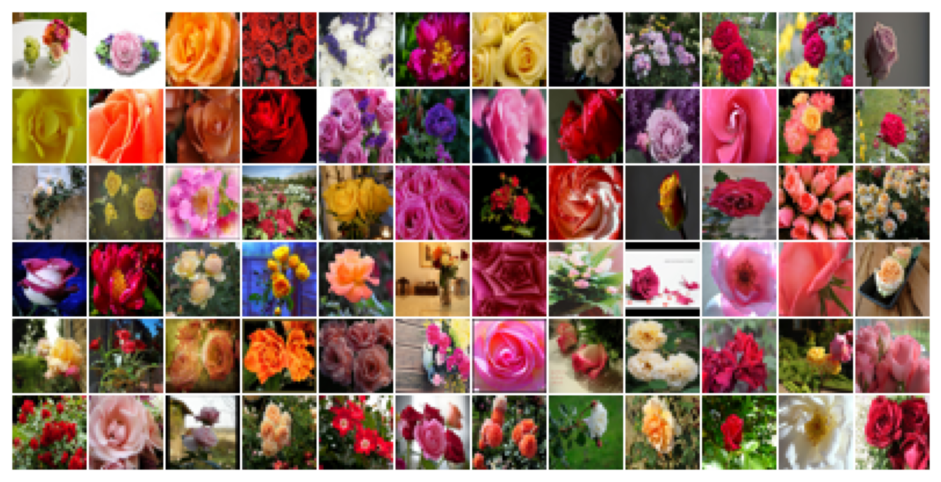

In [9]:
visualize_data(dataset_name=BaseConfig.DATASET, amount=72)

# Diffusion Process

In [10]:
class SimpleDiffusion:
    def __init__(
        self,
        num_diffusion_timesteps=1000,
        img_shape=(3, 64, 64),
        device="cpu",
    ):
        self.num_diffusion_timesteps = num_diffusion_timesteps
        self.img_shape = img_shape
        self.device = device

        self.initialize()

    def initialize(self):
        # BETAs & ALPHAs required at different places in the Algorithm.
        self.beta  = self.get_betas()
        self.alpha = 1 - self.beta
        
        self_sqrt_beta                       = torch.sqrt(self.beta)
        self.alpha_cumulative                = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumulative           = torch.sqrt(self.alpha_cumulative)
        self.one_by_sqrt_alpha               = 1. / torch.sqrt(self.alpha)
        self.sqrt_one_minus_alpha_cumulative = torch.sqrt(1 - self.alpha_cumulative)
         
    def get_betas(self):
        # linear schedule
        scale = 1000 / self.num_diffusion_timesteps
        beta_start = scale * 1e-4
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start,
            beta_end,
            self.num_diffusion_timesteps,
            dtype=torch.float32,
            device=self.device,
        )
    

$$
\Large x_t = \sqrt{\bar a_t}x_0 + \sqrt{1-\bar a_t}\epsilon
$$

In [11]:
def forward_diffusion(sd: SimpleDiffusion, x0: torch.Tensor, timesteps: torch.Tensor):
    # Noise
    e = torch.randn_like(x0)  
    # image scaled + noise scaled
    x_t  = (get(sd.sqrt_alpha_cumulative, t=timesteps) * x0 + 
               get(sd.sqrt_one_minus_alpha_cumulative, t=timesteps) * e)

    # return corrupted input and the corresponding noise applied
    return x_t, e   

# Training

In [12]:
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
model.to(BaseConfig.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LR)

dataloader = get_dataloader(
    dataset_name  = BaseConfig.DATASET,
    batch_size    = TrainingConfig.BATCH_SIZE,
    device        = BaseConfig.DEVICE,
    pin_memory    = True,
    num_workers   = TrainingConfig.NUM_WORKERS,
)

loss_fn = nn.MSELoss()

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

scaler = amp.GradScaler()

C:\Users\Grazv\miniconda3\envs\pyTorch_DDPM\lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [13]:
log_dir, checkpoint_dir = setup_log_directory(config=BaseConfig())

generate_video = True
ext = ".mp4" if generate_video else ".png"

Logging at: Logs_Checkpoints\Inference\version_4
Model Checkpoint at: Logs_Checkpoints\checkpoints\version_4


![](.\resources\training.png)

In [14]:
# Algorithm 1: Training

def train_one_epoch(model, sd, loader, optimizer, scaler, loss_fn, epoch=800, 
                   base_config=BaseConfig(), training_config=TrainingConfig()):
    
    loss_record = MeanMetric()
    model.train()

    with tqdm(total=len(loader), dynamic_ncols=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch}/{training_config.NUM_EPOCHS}")
    
        for x0s, _ in loader:
            tq.update(1)
            ts = torch.randint(low=1, high=training_config.TIMESTEPS, size=(x0s.shape[0],), device=base_config.DEVICE)
            xts, gt_noise = forward_diffusion(sd, x0s, ts)
            
            with amp.autocast():
                pred_noise = model(xts, ts)
                loss = loss_fn(gt_noise, pred_noise)
                
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # scaler.unscale_(optimizer)
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            loss_value = loss.detach().item()
            loss_record.update(loss_value)

            tq.set_postfix_str(s=f"Loss: {loss_value:.4f}")

        mean_loss = loss_record.compute().item()
    
        tq.set_postfix_str(s=f"Epoch Loss: {mean_loss:.4f}")
    
    return mean_loss 

# Sampling

![](.\resources\sampling.png)

In [15]:
# generates "num_images"-amount of samples
    
@torch.no_grad()
def generate_samples(model, sd, timesteps=1000, img_shape=(3, 64, 64), 
                      num_images=5, device="cpu", inference_logger=None):

    #1: x_T ~ N(0,1)
    # (actually in multiples: x := [x1_T, x2_T ..., x(num_images)_T] )
    x = torch.randn((num_images, *img_shape), device=device)
    model.eval()

    #2: for t = T, ... ,1 do
    for time_step in tqdm(iterable=reversed(range(1, timesteps)), 
                          total=timesteps-1, dynamic_ncols=False, 
                          desc="Sampling :: ", position=0):

        #3: z ~ N(0,1) if t > 0, else z = 0
        z = torch.randn_like(x) if time_step > 1 else torch.zeros_like(x)

        ts = torch.ones(num_images, dtype=torch.long, device=device) * time_step
        predicted_noise = model(x, ts)
        beta_t                            = get(sd.beta, ts)
        one_by_sqrt_alpha_t               = get(sd.one_by_sqrt_alpha, ts)
        sqrt_one_minus_alpha_cumulative_t = get(sd.sqrt_one_minus_alpha_cumulative, ts) 

        #4: x_{t-1} = ...
        x = (
            one_by_sqrt_alpha_t
            * (x - (beta_t / sqrt_one_minus_alpha_cumulative_t) * predicted_noise)
            + torch.sqrt(beta_t) * z
        )

        inference_logger.update(x)

    #6: return x_0
    inference_logger.save_result(x)

Everything in action

Train :: Epoch: 1/200:   0%|          | 0/70 [00:00<?, ?it/s]C:\Users\Grazv\miniconda3\envs\pyTorch_DDPM\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Sampling :: 100%|██████████| 999/999 [05:05<00:00,  3.28it/s]


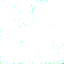

Sampling :: 100%|██████████| 999/999 [06:55<00:00,  2.41it/s]


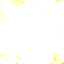

Train :: Epoch: 41/200:  69%|██████▊   | 48/70 [01:05<00:29,  1.36s/it, Loss: 0.0149]


KeyboardInterrupt: 

In [16]:
for epoch in range(1, TrainingConfig.NUM_EPOCHS + 1):
    torch.cuda.empty_cache()
    gc.collect()
    
    # Algorithm 1: Training
    train_one_epoch(model, sd, dataloader, optimizer, scaler, loss_fn, epoch=epoch)
    
    if epoch % 20 == 0:
        save_path = os.path.join(log_dir, f"{epoch}{ext}")
        
        # Algorithm 2: Sampling
        generate_samples(
            model, sd, timesteps=TrainingConfig.TIMESTEPS, num_images=1,
            inference_logger=InferenceLogger(generate_video, save_path),img_shape=TrainingConfig.IMG_SHAPE, device=BaseConfig.DEVICE,
        )

        checkpoint_dict = {
            "opt": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "model": model.state_dict()
        }
        torch.save(checkpoint_dict, os.path.join(checkpoint_dir, "ckpt.tar"))
        del checkpoint_dict

In [ ]:
# !rm -rf /kaggle/working/Logs_Checkpoints

# Inference

In [17]:
model = UNet(
    input_channels          = TrainingConfig.IMG_SHAPE[0],
    output_channels         = TrainingConfig.IMG_SHAPE[0],
    base_channels           = ModelConfig.BASE_CH,
    base_channels_multiples = ModelConfig.BASE_CH_MULT,
    apply_attention         = ModelConfig.APPLY_ATTENTION,
    dropout_rate            = ModelConfig.DROPOUT_RATE,
    time_multiple           = ModelConfig.TIME_EMB_MULT,
)
path = os.path.join(BaseConfig.root_checkpoint_dir,"version_4","ckpt.tar")
model.load_state_dict(torch.load(path, map_location='cpu')['model'])

model.to(BaseConfig.DEVICE)

sd = SimpleDiffusion(
    num_diffusion_timesteps = TrainingConfig.TIMESTEPS,
    img_shape               = TrainingConfig.IMG_SHAPE,
    device                  = BaseConfig.DEVICE,
)

log_dir = "inference_results"
os.makedirs(log_dir, exist_ok=True)

Sampling :: 100%|██████████| 799/799 [04:36<00:00,  2.89it/s]


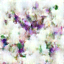

inference_results\20240626-211242.mp4


In [22]:
generate_video = True

ext = ".mp4" if generate_video else ".png"
filename = f"{datetime.now().strftime('%Y%m%d-%H%M%S')}{ext}"

save_path = os.path.join(log_dir, filename)

generate_samples(
    model,
    sd,
    num_images=8,#16,
    inference_logger=InferenceLogger(generate_video, save_path, nrow=4),
    timesteps=500,
    img_shape=TrainingConfig.IMG_SHAPE,
    device=BaseConfig.DEVICE,
)
print(save_path)